In [148]:
# load packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import librosa
import h5py
from tqdm import tqdm

In [150]:
# load GTZAN rep learn data
hf = h5py.File('../data/feature50/individual/conv_2d_artist_50_0.0001_GTZAN_feature.h5')
X = hf['X'][:]
y = hf['y'][:]

In [41]:
# calculate mfccs for each GTZAN
data_info = pd.read_csv(
    '/mnt/bulk2/datasets/GTZAN/GTZAN.dataset.info',
    sep='\t', header=None, names=['id', 'path', 'class'], index_col=0)

M = []
for i, [path, cls] in tqdm(zip(data_info.index, data_info.as_matrix().tolist())):
    mfcc = librosa.feature.mfcc(*librosa.load(path))
    M.append((i, mfcc))
    

100%|██████████| 1000/1000 [05:42<00:00,  2.94it/s]


In [44]:
shortest_len = min(map(lambda x:x[1].shape[-1], M))
MFCC = np.array(map(lambda x:x[1][:,:shortest_len], M))

In [188]:
# cluster reps in K-Means
K = 12
kms = KMeans(n_clusters=K)
c = kms.fit_predict(X)

mfcc_means = []
for k in range(K):
    k_ix = np.where(c==k)[0]
    mfcc_means.append(np.concatenate(MFCC[k_ix].transpose(0,2,1),axis=0).mean(axis=0))
mfcc_means = np.array(mfcc_means)

# sclr = StandardScaler()
# mfcc_means = sclr.fit_transform(mfcc_means)

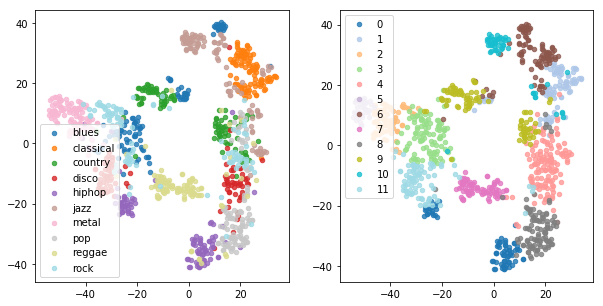

In [205]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x = tsne.fit_transform(X)

fig, axs = plt.subplots(1,2,figsize=(10,5))

# plot by label
colors = [plt.cm.Vega20(float(i)/9) for i in range(10)]
for i in range(10):
    cls_idx = np.where(y==i)[0]
    axs[0].scatter(x[cls_idx,0], x[cls_idx,1], alpha=0.8, s=20,
                   c=colors[i], label=hf['labels'][i])
axs[0].legend()


# plot by cluster
colors = [plt.cm.Vega20(float(i)/(K-1)) for i in range(K)]
for k in range(K):
    cls_idx = np.where(c==k)[0]
    axs[1].scatter(x[cls_idx,0], x[cls_idx,1], alpha=0.8, s=20,
                   c=colors[k], label=k)
axs[1].legend()


<Container object of 12 artists>

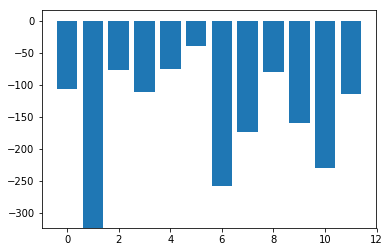

In [201]:
plt.bar(range(K), mfcc_means[:,0])

## BASELINE TEST w/ MFCC-GMM

In [142]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

gmm_mfcc = []
for m in tqdm(MFCC):
    gmm_mfcc.append(GaussianMixture(n_components=5, covariance_type='diag'))
    gmm_mfcc[-1].fit(m.T)

100%|██████████| 1000/1000 [00:33<00:00, 34.61it/s]


             precision    recall  f1-score   support

        0.0       0.26      0.38      0.31       100
        1.0       0.84      0.76      0.80       100
        2.0       0.33      0.32      0.32       100
        3.0       0.29      0.41      0.34       100
        4.0       0.34      0.28      0.31       100
        5.0       0.64      0.58      0.61       100
        6.0       0.70      0.69      0.70       100
        7.0       0.62      0.56      0.59       100
        8.0       0.40      0.33      0.36       100
        9.0       0.26      0.20      0.22       100

avg / total       0.47      0.45      0.46      1000

0.451


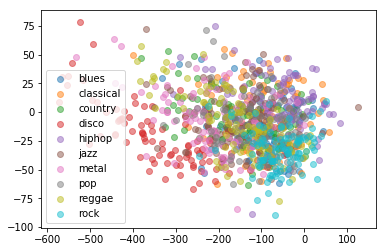

In [147]:
trg_dim = (0, 2)
for i in range(0, 1000, 100):
    plt.scatter(
#         MFCC[i:i+100,trg_dim[0],::40],
#         MFCC[i:i+100,trg_dim[1],::40],
        map(lambda gmm:gmm.means_[0][trg_dim[0]], gmm_mfcc[i:i+100]),
        map(lambda gmm:gmm.means_[0][trg_dim[1]], gmm_mfcc[i:i+100]),
        alpha=0.5,
        label=hf['labels'][i/100]
    )
plt.legend()

concat = np.concatenate

clf_baseline(
    np.array(
        map(lambda gmm:
        concat([concat(gmm.means_),concat(gmm.covariances_)]),
        gmm_mfcc)),
    y,
    cv=5
)



In [145]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

def clf_baseline(X, y, cv=10):
#     sclr = StandardScaler()
    sclr = PCA(n_components=128, whiten=True)
    clf = SVC(kernel='linear')
    pl = Pipeline([('preproc', sclr), ('clf', clf)])
    y_ = cross_val_predict(pl, X, y, cv=cv)
    print(classification_report(y, y_))
    print(accuracy_score(y, y_))
    
# clf_baseline(MFCC.reshape(1000,20*1290), y)
    